In [1]:
import warnings
from itertools import chain
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sklearn
import sklearn_crfsuite
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split, ShuffleSplit, learning_curve, RandomizedSearchCV
from sklearn_crfsuite import metrics, scorers

import features as features
import util as util

In [106]:
plt.style.use('ggplot')
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [3]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


In [4]:
def count_and_print_errors(n, f=None, seq=None):
    cnt = 0
    if seq is not None:
        cor_seq = {}
        wrg_seq = {}
    for i, s_true_y in enumerate(test_y):
        if cnt == n:
            break
        s_pred_y = y_pred[i]
        s_x = zipped_test_x[i]
        for j, true_y in enumerate(s_true_y):
            if cnt == n:
                break
            x = s_x[j]
            pred_y = s_pred_y[j]
            if true_y != pred_y:
                cnt += 1
                if f:
                    print(" ".join([w['word'] for w in s_x]), file=f)
                    print([w['word_postag'] for w in s_x], file=f)
                    print([w for w in s_pred_y], file=f)
                    print([w for w in s_true_y], file=f)
                    print('\n', file=f)
                if seq is not None and '-1:postag' in x:
                    key = f'{x["-1:postag"]}-{x["word_postag"]}'
                    wrg_seq[key] = wrg_seq.setdefault(key, 0) + 1
            elif seq is not None and '-1:postag' in x:
                key = f'{x["-1:postag"]}-{x["word_postag"]}'
                cor_seq[key] = cor_seq.setdefault(key, 0) + 1
    if seq is not None:
        keys = set(cor_seq.keys()) | set(wrg_seq.keys())
        for key in keys:
            seq[key] = cor_seq.get(key, 0) / (cor_seq.get(key, 0) + wrg_seq.get(key, 0))
    return cnt


In [5]:
def find_best_hyperparameters(estimator, data_x, data_y, labels):
    # use the same metric for evaluation
    f1_scorer = make_scorer(metrics.flat_f1_score, average='weighted', labels=labels)

    # Searching in params_space for best results
    params_space = {
        'c1': scipy.stats.expon(scale=0.5),
        'c2': scipy.stats.expon(scale=0.05),
    }
    rs = RandomizedSearchCV(estimator, params_space, cv=3, n_jobs=4, n_iter=50, scoring=f1_scorer)
    rs.fit(data_x, data_y)
    print('best params:', rs.best_params_)
    print('best CV score:', rs.best_score_)
    print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))
    return rs.best_estimator_


# Declaring Feature Sets

In [6]:
# This is for deciding on what features we need to do our analysis
MODE_LIST = [0, 1, 2, 3, 8, 11, 16, 24]
## Mode Bits
# 0 - Gender
# 1 - Number
# 2 - Person
# 3 - Case
# 4 - Root Word & Whether same


In [111]:
print('Loading data...')

data = util.convertFromSSF('data_clean.txt')
print(f'# of sentences = {len(data)}')
data_x = [features.sentToFeatures(s, MODE_LIST) for s in data]
data_y = [features.sentToLabels(s) for s in data]

# Setting the training and testing data
print('Splitting data at 70%:30%...')
train_X, test_X, train_Y, test_y = train_test_split(data_x, data_y, test_size=0.3, random_state=123)

Loading data...
# of sentences = 21086
Splitting data at 70%:30%...


# Finding classification labels

In [112]:
labels = set(chain(*data_y))
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)

# Setting the model

In [113]:
# c1 and c2 parameter values are obtained from randomized search in hyperparameters space
# Best estimated F1 score = 0.9745285762169615
crf = sklearn_crfsuite.CRF(algorithm="lbfgs", c1=0.2096570893088954, c2=0.038587807344039826, max_iterations=50, all_possible_transitions=True)

In [114]:
# find_best_hyperparameters(crf, [s[1] for s in train_X], train_Y, sorted_labels)

# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
# cv = ShuffleSplit(n_splits=2, test_size=0.2, random_state=0)

# Fit, Predict & Report for each feature set

In [115]:
## Working for each mode differently
report = {}
for mode in MODE_LIST:
    zipped_train_x = [s[mode] for s in train_X]
    zipped_test_x = [s[mode] for s in test_X]
    # plot_learning_curve(crf, f'Learning curve for MODE {mode}', [s[mode] for s in train_X], train_Y, ylim=(0.7, 1.01), cv=cv, n_jobs=6)
    # plt.show()

    print('Fitting the model for MODE (' + str(mode) + ') ...')
    crf.fit(zipped_train_x, train_Y)

    print('Predicting labels...')
    y_pred = crf.predict(zipped_test_x)

    print('F1 score: ', metrics.flat_f1_score(test_y, y_pred, average='weighted'))

    report[mode] = metrics.flat_classification_report(
        test_y, y_pred, labels=sorted_labels, digits=3, output_dict=True
    )

    seq = {}
    itms = seq.items()
    print(f'# of Errors = {count_and_print_errors(-1, seq=seq)}')
    for j in (1.0, 0.9, 0.8, 0.7, 0.6, 0.5):
        print(f'# of Sequence-level combinations with accuracy < {j} = {len(dict(filter(lambda e: e[1] < j, itms)))}')
    print('Sequence-level combinations with accuracy < 0.4', dict(filter(lambda e: e[1] < 0.4, itms)))
    print()

Fitting the model for MODE (0) ...
Predicting labels...
F1 score:  0.9743432092164278
# of Errors = 3353
# of Sequence-level combinations with accuracy < 1.0 = 243
# of Sequence-level combinations with accuracy < 0.9 = 119
# of Sequence-level combinations with accuracy < 0.8 = 64
# of Sequence-level combinations with accuracy < 0.7 = 47
# of Sequence-level combinations with accuracy < 0.6 = 30
# of Sequence-level combinations with accuracy < 0.5 = 21
Sequence-level combinations with accuracy < 0.4 {'SYM-INJC': 0.0, 'RDP-QCC': 0.0, 'INJC-INJ': 0.0, 'VAUX-INJ': 0.0, 'INJ-INJ': 0.0, 'NNP-QC': 0.3333333333333333, 'UNK-NNP': 0.0, 'SYM-VAUX': 0.0, 'NNP-NST': 0.18181818181818182, 'UNK-SYM': 0.3333333333333333, 'NEG-NEG': 0.0, 'QC-QCC': 0.0, 'UNK-NNPC': 0.0, 'RDP-NST': 0.0, 'SYM-JJC': 0.3333333333333333, 'VM-UNK': 0.0, 'QO-PRP': 0.0, 'WQ-NST': 0.0, 'INJC-INJC': 0.0}

Fitting the model for MODE (1) ...
Predicting labels...
F1 score:  0.9742207922785058
# of Errors = 3370
# of Sequence-level com

In [116]:
res = {}
for mode, dct in report.items():
    for lbl, dct2 in dct.items():
        if lbl[0] not in ('B', 'I') or 'NULL' in lbl:
            continue
        for key, val in dct2.items():
            res.setdefault(key, dict())
            res[key].setdefault(mode, dict())
            res[key][mode][lbl] = val

In [132]:
def subcategorybar(X, vals, lbls, width=0.8):
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                width=width/float(n), align="edge", label=lbls[i])
    plt.xticks(_X, X)

In [152]:
def plot_score(data, ylabel='Metric value', title=None):
    plt.figure(figsize=(20, 12))
    if title:
        plt.title(title)
    X=[list(lbl.keys()) for lbl in data.values()][0]
    Y=[list(map(lambda val: 100*val, lbl.values())) for lbl in data.values()]
    subcategorybar(X, Y, lbls=[f'Mode {v}' for v in data.keys()], width=0.8)
    plt.ylabel(ylabel)
    plt.xlabel('Classes')
    plt.ylim(bottom=20)
    plt.legend()
    plt.show()

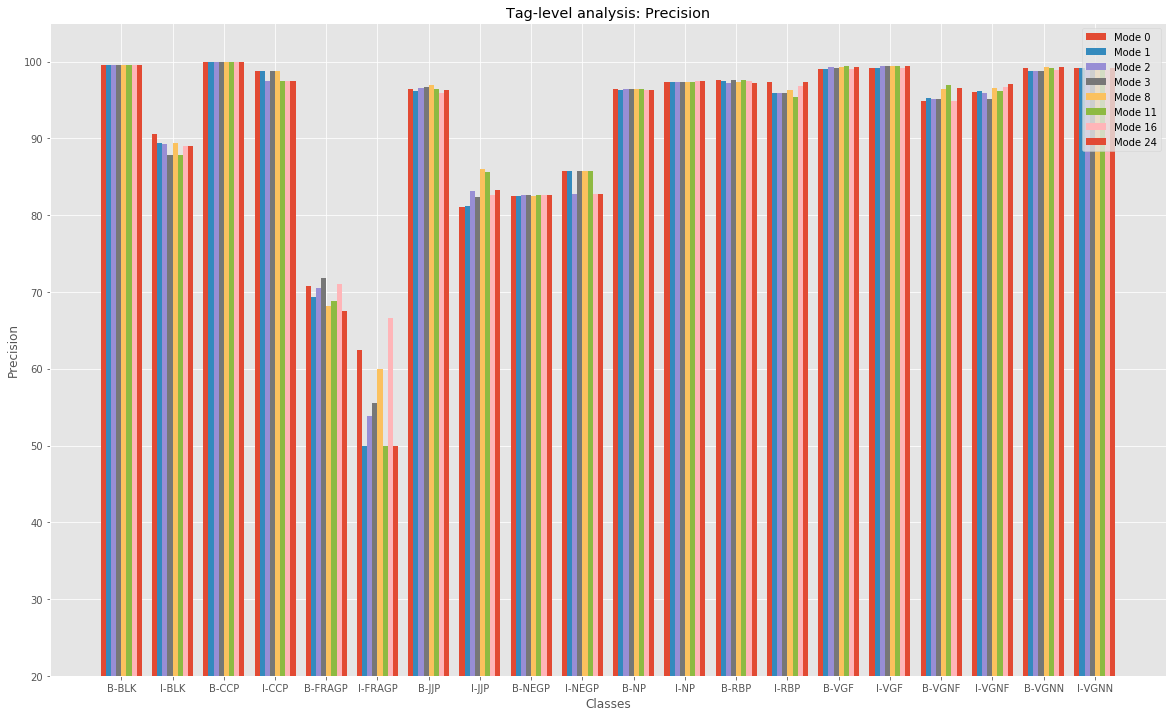

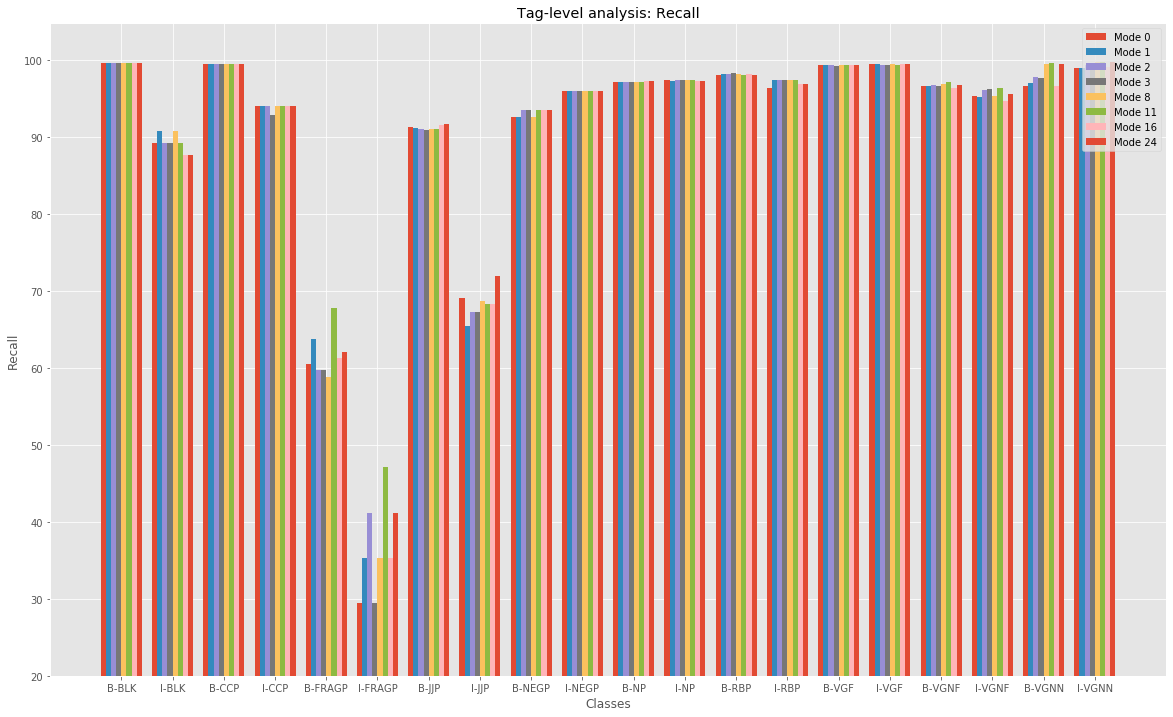

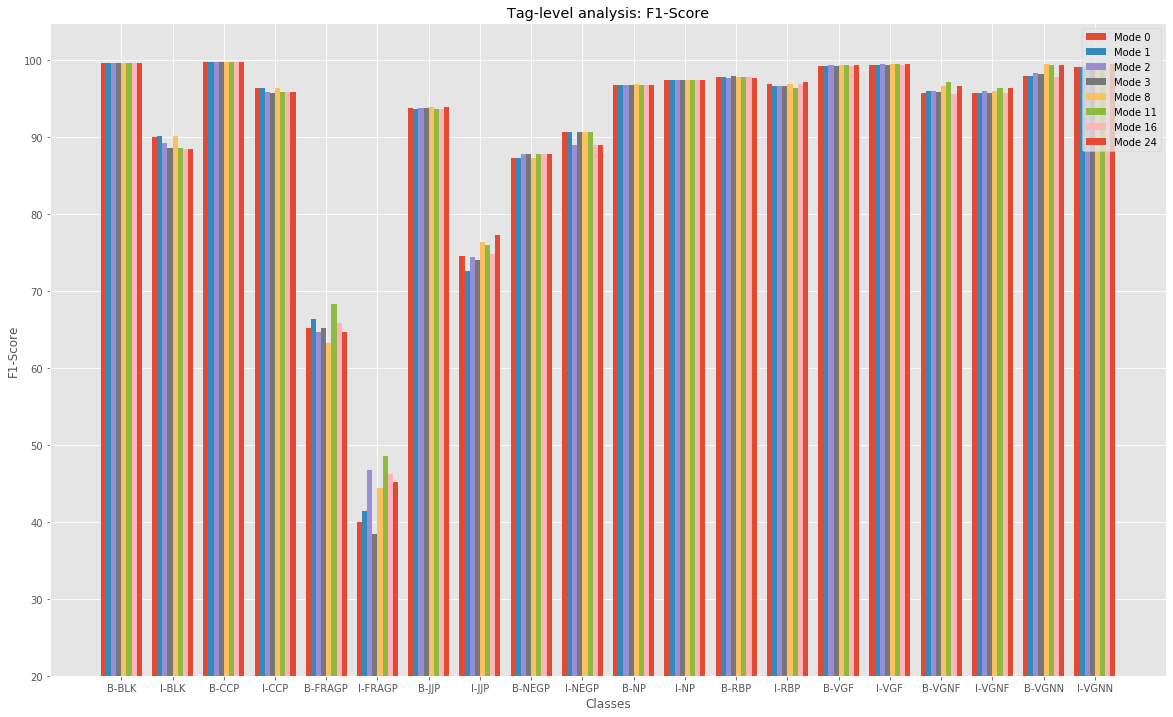

In [153]:
plot_score(res['precision'], ylabel="Precision", title='Tag-level analysis: Precision')
plot_score(res['recall'], ylabel="Recall", title='Tag-level analysis: Recall')
plot_score(res['f1-score'], ylabel="F1-Score", title='Tag-level analysis: F1-Score')